# Playing Pac-Man with Deep Q-Learning

Parts of this notebook has been reproduced from the [Hands-On Machine Learning with Scikit-Learn and TensorFlow](https://www.amazon.co.uk/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291) book.

Additional installation of packages is required to get this working:
- For windows: `pip install --no-index -f https://github.com/Kojoley/atari-py/releases atari_py`

From [this](https://stackoverflow.com/a/46739299/490332) stackoverflow question. 

Testing the environment to ensure everything is working:

In [1]:
from collections import namedtuple
from itertools import count
import random

import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T

In [2]:
env = gym.make('MsPacman-v0')
obs = env.reset()
obs.shape

(210, 160, 3)

In [3]:
len(env.step(0))

4

In [4]:
env.action_space

Discrete(9)

We have 9 discrete possible actions to mimic those possible on the joystick:
- left
- right
- up
- down
- centre
- upper left
- upper right
- lower left
- lower right

The observations of the game are 3D numpy arrays. To increase computation speed, the 3D arrays will be converted to greyscale and also reduced in resolution to 88 x 80 with the following function:

In [5]:
pacman = np.array([210, 164, 74]).mean()
def preprocess_game_imge(observation: np.array) -> np.array:
    img = obs[1:176:2, ::2]
    img = img.mean(axis=2)
    img[img==pacman] = 0 # improve the constrast of pacman
    img = (img // 3 - 128).astype(np.uint8) # normalise from -1 to 1
    return img.reshape(88, 80, 1)

In [6]:
preprocess_game_imge(obs).shape

(88, 80, 1)

(-0.5, 79.5, 87.5, -0.5)

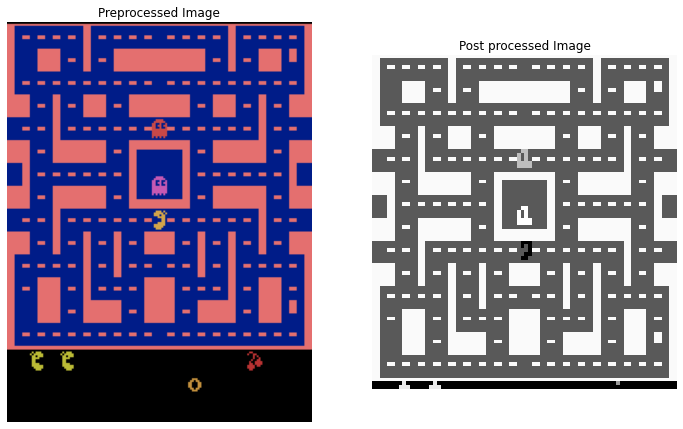

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(obs)
ax[0].set_title('Preprocessed Image')
ax[0].axis('off')
ax[1].imshow(preprocess_game_imge(obs).reshape(88, 80), interpolation='nearest', cmap='gray')
ax[1].set_title('Post processed Image')
ax[1].axis('off')

In [138]:
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 8, stride=4, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.linear1 = nn.Linear(7040, 512)
        self.linear2 = nn.Linear(512, 9)
        
    def forward(self, input_tensor):
        out = F.relu(self.conv1(input_tensor))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
#         out = torch.flatten(out)
        out = out.view(out.size(0), -1)
#         print(out.size(), 'in nn')
        out = F.relu(self.linear1(out))
        return self.linear2(out)

In [9]:
Image2Tensor = T.ToTensor()

In [109]:
actor_dqn = DQN()
critic_dqn = DQN()

In [110]:
actor_dqn.load_state_dict(critic_dqn.state_dict())
actor_dqn.eval()

DQN(
  (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (linear1): Linear(in_features=7040, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=9, bias=True)
)

In [111]:
actor_dqn(Image2Tensor(preprocess_game_imge(obs)).unsqueeze(0))

tensor([[-0.0371,  0.0182,  0.0242, -0.0481, -0.0340, -0.0402,  0.0297, -0.0146,
          0.0038]], grad_fn=<AddmmBackward>)

In [112]:
actor_dqn(Image2Tensor(preprocess_game_imge(obs)).unsqueeze(0)).

SyntaxError: invalid syntax (<ipython-input-112-8d204a62124a>, line 1)

In [14]:
torch.rand(2,3,3).max(1)[1]

tensor([[0, 1, 1],
        [0, 2, 2]])

In [139]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [140]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [141]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
#             return policy_net(state.unsqueeze(0)).max(1)[1].view(1, 1)
#             print(state.unsqueeze(0).size())
            actions = policy_net(state.unsqueeze(0))
            if len(actions.size()) == 1:
                return actions.view(1,9).max(1)[1].view(1,1)
#             print(len(policy_net(state.unsqueeze(0)).size()))
            else:
                return policy_net(state.unsqueeze(0)).max(1)[1].view(1,1)
    else:
        n_actions = 9 # number of actions possible in the game
        return torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)

In [142]:
steps_done = 0

BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [143]:
policy_net = DQN()
target_net = DQN()

In [144]:
optimiser = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(10000)

In [145]:
episode_durations = []

In [150]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_batch = state_batch.view(128,1,88,80) # resize to 4D
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1)[0].
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE)
    non_final_next_states = non_final_next_states.view(non_final_next_states.size()[0], 1, 88, 80)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimiser.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimiser.step()

In [151]:
num_episodes = 50
for i_episode in range(num_episodes):
    # Initialize the environment and state
    state = env.reset()
    state = Image2Tensor(preprocess_game_imge(state))
    current_state = state
    for t in count():
        # Select and perform an action
        action = select_action(state)
        state, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward])

        # Observe new state
        last_state = current_state
        current_state = Image2Tensor(preprocess_game_imge(state))
        if not done:
            next_state = current_state
        else:
            next_state = None

        # Store the transition in memory
        memory.push(last_state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        optimize_model()
        if done:
            episode_durations.append(t + 1)
#             plot_durations()
            break
    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

print('Complete')

KeyboardInterrupt: 